# Notebook Imports

In [1]:
!pip install prince

  Obtaining dependency information for prince from https://files.pythonhosted.org/packages/ea/47/05a78e27a6c7f85b5e006169e4ddf27637867124ef841176f5e4f5ce7f88/prince-0.13.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.6/415.6 kB 7.8 MB/s eta 0:00:00


In [2]:
import os
import re
import pandas as pd
import numpy as np
from datetime import date
import seaborn as sns
from scipy import stats
from umap import UMAP

import matplotlib.pyplot as plt
import warnings
from prince import MCA, CA
from sklearn.impute import SimpleImputer
import calendar
from yellowbrick.cluster import SilhouetteVisualizer

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.manifold import TSNE

warnings.filterwarnings('ignore')

# Constants

In [3]:
FILE = '/kaggle/input/data-science-for-good/Dept_11-00091/11-00091_Field-Interviews_2011-2015.csv'

# Step 1: Data Exploration and Preprocessing

### Load data

In [4]:
data = pd.read_csv(FILE)
df_full = pd.DataFrame(data)

df = df_full.sample(frac=0.1)

# df.drop([0], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,INCIDENT_UNIQUE_IDENTIFIER,INCIDENT_UNIQUE_IDENTIFIER.1,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,INCIDENT_TIME,SUBJECT_DETAILS,SUBJECT_RACE,...,VEHICLE_DETAILS.1,OFFICER_SUPERVISOR,OFFICER_ID,OFFICER_ASSIGNMENT,OFFICER_ASSIGNMENT.1,OFFICER_ETHNICITY,OFFICER_RACE,OFFICER_AGE,LOCATION_STREET_NUMBER,LOCATION_CITY
0,909382,592843,MALE,284 COLUMBIA RD,B2,3,2/7/13 0:00,2/7/13 0:00,NaN,W(White),...,NO DATA ENTERED,86124.0,81410,16,YVSF,NaN,W(White),15,1020,NO DATA ENTERED
1,767877,527603,MALE,00 ARLINGTON ST,D4,8,7/4/11 0:00,7/4/11 0:00,UNKNOWN,M(Middle Eastern or East Indian),...,OTHER,NaN,10528,8,D4,NaN,M(Middle Eastern or East Indian),20,207,Jamaica Plain
2,909667,593128,MALE,00 SUMNER ST at MAVERICK SQ,A7,2,2/22/13 0:00,2/22/13 0:00,NO,B(Black),...,NO DATA ENTERED,9970,92445,2,A7,BNH,B(Black),18,4356,East Boston
3,886339,569627,MALE,0 HORADAN WY at PARKER ST,B2,3,1/3/11 0:00,1/3/11 0:00,YES,B(Black),...,NO DATA ENTERED,12283.0,106719,3,B2,NaN,B(Black),23,2294,Roxbury
4,912896,596389,MALE,451 WASHINGTON ST,C11,5,3/18/13 0:00,3/18/13 0:00,YES,B(Black),...,NO DATA ENTERED,10739.0,98663,16,YVSF,NaN,B(Black),26,4771,NO DATA ENTERED


In [5]:
df['INCIDENT_REASON'].value_counts()

INCIDENT_REASON
INVESTIGATIVE              6081
OTHER (SPECIFY)            1774
RADIO CALL                 1566
MOTOR VEHICLE VIOLATION    1093
CRIMINAL VIOLATION           61
CITIZEN ASSIST               12
Name: count, dtype: int64

In [6]:
print(f"\nThe shape of the data: {df.shape}\n")
print(f"The types of the data: \n{df.dtypes}\n")
print(f"The empty row in the data: \n{df.isnull().sum()}")


The shape of the data: (15223, 34)

The types of the data: 
INCIDENT_UNIQUE_IDENTIFIER                      object
INCIDENT_UNIQUE_IDENTIFIER.1                    object
SUBJECT_GENDER                                  object
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION    object
LOCATION_DISTRICT                               object
LOCATION_DISTRICT.1                             object
INCIDENT_DATE                                   object
INCIDENT_TIME                                   object
SUBJECT_DETAILS                                 object
SUBJECT_RACE                                    object
SUBJECT_DETAILS.1                               object
SUBJECT_DETAILS.2                               object
UNKNOWN_FIELD_TYPE                              object
UNKNOWN_FIELD_TYPE.1                            object
SEARCH_CONDUCTED                                object
SEARCH_REASON                                   object
INCIDENT_REASON                                 object
INCI

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 34 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   INCIDENT_UNIQUE_IDENTIFIER                    15223 non-null  object
 1   INCIDENT_UNIQUE_IDENTIFIER.1                  15223 non-null  object
 2   SUBJECT_GENDER                                15223 non-null  object
 3   LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION  15223 non-null  object
 4   LOCATION_DISTRICT                             15223 non-null  object
 5   LOCATION_DISTRICT.1                           15223 non-null  object
 6   INCIDENT_DATE                                 15223 non-null  object
 7   INCIDENT_TIME                                 15223 non-null  object
 8   SUBJECT_DETAILS                               13148 non-null  object
 9   SUBJECT_RACE                                  15223 non-null  object
 10

### Data Cleaning

In [8]:
# converting 'NO DATA ENTERED', 'UNKNOWN' values in columns to NaN values
for feature in df.columns:
    df[feature].replace(to_replace=["NO DATA ENTERED", 'UNKNOWN', '0', 0, 'FIO_DATE', 
                                   'AGE_AT_FIO_CORRECTED', 'DISCRIPTION'], value=np.nan, inplace=True)

In [9]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
INCIDENT_UNIQUE_IDENTIFIER                          0
INCIDENT_UNIQUE_IDENTIFIER.1                        0
SUBJECT_GENDER                                     21
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION        0
LOCATION_DISTRICT                                   0
LOCATION_DISTRICT.1                                 0
INCIDENT_DATE                                       0
INCIDENT_TIME                                       0
SUBJECT_DETAILS                                  2235
SUBJECT_RACE                                      661
SUBJECT_DETAILS.1                                1359
SUBJECT_DETAILS.2                                2314
UNKNOWN_FIELD_TYPE                                  0
UNKNOWN_FIELD_TYPE.1                                0
SEARCH_CONDUCTED                                13203
SEARCH_REASON                                   11707
INCIDENT_REASON                                  4636
INCIDENT_REASON.1                                   0


In [10]:
# dropping columns where the NaN values were more than 4000
for feature in df.columns:
    if df[feature].isnull().sum() > 4000:
        df.drop([feature], axis=1, inplace=True)

In [11]:
df.head()

,INCIDENT_UNIQUE_IDENTIFIER,INCIDENT_UNIQUE_IDENTIFIER.1,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,INCIDENT_TIME,SUBJECT_DETAILS,SUBJECT_RACE,...,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON.1,DISPOSITION,OFFICER_SUPERVISOR,OFFICER_ID,OFFICER_ASSIGNMENT,OFFICER_ASSIGNMENT.1,OFFICER_RACE,OFFICER_AGE,LOCATION_STREET_NUMBER
0,909382,592843,MALE,284 COLUMBIA RD,B2,3,2/7/13 0:00,2/7/13 0:00,NaN,W(White),...,NO,"INVESTIGATE, PERSON",F,86124.0,81410,16,YVSF,W(White),15,1020
1,767877,527603,MALE,00 ARLINGTON ST,D4,8,7/4/11 0:00,7/4/11 0:00,NaN,M(Middle Eastern or East Indian),...,NO,"INVESTIGATE, PERSON",F,NaN,10528,8,D4,M(Middle Eastern or East Indian),20,207
2,909667,593128,MALE,00 SUMNER ST at MAVERICK SQ,A7,2,2/22/13 0:00,2/22/13 0:00,NO,B(Black),...,NO,"INVESTIGATE, PERSON",F,9970,92445,2,A7,B(Black),18,4356
3,886339,569627,MALE,0 HORADAN WY at PARKER ST,B2,3,1/3/11 0:00,1/3/11 0:00,YES,B(Black),...,NO,"INVESTIGATE, PERSON",F,12283.0,106719,3,B2,B(Black),23,2294
4,912896,596389,MALE,451 WASHINGTON ST,C11,5,3/18/13 0:00,3/18/13 0:00,YES,B(Black),...,NO,"INVESTIGATE, PERSON",F,10739.0,98663,16,YVSF,B(Black),26,4771


In [12]:
# Number of unique values in the dataset columns
for feature in df.columns:
    print(f'Number of unique values in {feature} column:', len(df[feature].unique()))

Number of unique values in INCIDENT_UNIQUE_IDENTIFIER column: 15223
Number of unique values in INCIDENT_UNIQUE_IDENTIFIER.1 column: 15223
Number of unique values in SUBJECT_GENDER column: 3
Number of unique values in LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION column: 9108
Number of unique values in LOCATION_DISTRICT column: 19
Number of unique values in LOCATION_DISTRICT.1 column: 35
Number of unique values in INCIDENT_DATE column: 1725
Number of unique values in INCIDENT_TIME column: 1725
Number of unique values in SUBJECT_DETAILS column: 3
Number of unique values in SUBJECT_RACE column: 7
Number of unique values in SUBJECT_DETAILS.1 column: 12122
Number of unique values in SUBJECT_DETAILS.2 column: 10
Number of unique values in UNKNOWN_FIELD_TYPE column: 17
Number of unique values in UNKNOWN_FIELD_TYPE.1 column: 2
Number of unique values in INCIDENT_REASON.1 column: 142
Number of unique values in DISPOSITION column: 8
Number of unique values in OFFICER_SUPERVISOR column: 217
Number

In [13]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
INCIDENT_UNIQUE_IDENTIFIER                         0
INCIDENT_UNIQUE_IDENTIFIER.1                       0
SUBJECT_GENDER                                    21
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION       0
LOCATION_DISTRICT                                  0
LOCATION_DISTRICT.1                                0
INCIDENT_DATE                                      0
INCIDENT_TIME                                      0
SUBJECT_DETAILS                                 2235
SUBJECT_RACE                                     661
SUBJECT_DETAILS.1                               1359
SUBJECT_DETAILS.2                               2314
UNKNOWN_FIELD_TYPE                                 0
UNKNOWN_FIELD_TYPE.1                               0
INCIDENT_REASON.1                                  0
DISPOSITION                                      876
OFFICER_SUPERVISOR                              1657
OFFICER_ID                                         0
OFFICER_ASSIGNMENT

In [14]:
df.shape

(15223, 23)

In [15]:
df.drop(['INCIDENT_UNIQUE_IDENTIFIER', 'INCIDENT_UNIQUE_IDENTIFIER.1', 'OFFICER_ID', 'INCIDENT_TIME', 'OFFICER_SUPERVISOR', 
         'OFFICER_ASSIGNMENT', 'LOCATION_STREET_NUMBER', 'SUBJECT_DETAILS.1', 'OFFICER_RACE', 
         'LOCATION_DISTRICT.1', 'UNKNOWN_FIELD_TYPE.1', 'UNKNOWN_FIELD_TYPE', 'DISPOSITION'], axis=1, inplace=True)

In [16]:
df.shape

(15223, 10)

In [17]:
df.head()

,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,INCIDENT_DATE,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,INCIDENT_REASON.1,OFFICER_ASSIGNMENT.1,OFFICER_AGE
0,MALE,284 COLUMBIA RD,B2,2/7/13 0:00,NaN,W(White),Light,"INVESTIGATE, PERSON",YVSF,15
1,MALE,00 ARLINGTON ST,D4,7/4/11 0:00,NaN,M(Middle Eastern or East Indian),Dark,"INVESTIGATE, PERSON",D4,20
2,MALE,00 SUMNER ST at MAVERICK SQ,A7,2/22/13 0:00,NO,B(Black),Light,"INVESTIGATE, PERSON",A7,18
3,MALE,0 HORADAN WY at PARKER ST,B2,1/3/11 0:00,YES,B(Black),Dark,"INVESTIGATE, PERSON",B2,23
4,MALE,451 WASHINGTON ST,C11,3/18/13 0:00,YES,B(Black),Med,"INVESTIGATE, PERSON",YVSF,26


In [18]:
df.duplicated().value_counts()

False    15157
True        66
Name: count, dtype: int64

In [19]:
df.drop_duplicates(inplace=True)

In [20]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
SUBJECT_GENDER                                    21
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION       0
LOCATION_DISTRICT                                  0
INCIDENT_DATE                                      0
SUBJECT_DETAILS                                 2223
SUBJECT_RACE                                     657
SUBJECT_DETAILS.2                               2300
INCIDENT_REASON.1                                  0
OFFICER_ASSIGNMENT.1                               0
OFFICER_AGE                                       25
dtype: int64


In [21]:
# Handling missing values

mode_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
mode_imputer.fit(df)
imputed_data = mode_imputer.transform(df)
df = pd.DataFrame(data=imputed_data, columns=df.columns)
df.isnull().sum()

SUBJECT_GENDER                                  0
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION    0
LOCATION_DISTRICT                               0
INCIDENT_DATE                                   0
SUBJECT_DETAILS                                 0
SUBJECT_RACE                                    0
SUBJECT_DETAILS.2                               0
INCIDENT_REASON.1                               0
OFFICER_ASSIGNMENT.1                            0
OFFICER_AGE                                     0
dtype: int64

### Data Preprocessing

In [22]:
# Extracting dates

df['INCIDENT_DATE'] = pd.to_datetime(df['INCIDENT_DATE'], format="mixed")
df["INCIDENT_YEAR"] = df["INCIDENT_DATE"].dt.strftime('%Y')
df["INCIDENT_MONTH"] = df["INCIDENT_DATE"].dt.strftime('%B')

df.drop(['INCIDENT_DATE'], axis=1, inplace=True)

In [23]:
df.head()

,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,INCIDENT_REASON.1,OFFICER_ASSIGNMENT.1,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH
0,MALE,284 COLUMBIA RD,B2,YES,W(White),Light,"INVESTIGATE, PERSON",YVSF,15,2013,February
1,MALE,00 ARLINGTON ST,D4,YES,M(Middle Eastern or East Indian),Dark,"INVESTIGATE, PERSON",D4,20,2011,July
2,MALE,00 SUMNER ST at MAVERICK SQ,A7,NO,B(Black),Light,"INVESTIGATE, PERSON",A7,18,2013,February
3,MALE,0 HORADAN WY at PARKER ST,B2,YES,B(Black),Dark,"INVESTIGATE, PERSON",B2,23,2011,January
4,MALE,451 WASHINGTON ST,C11,YES,B(Black),Med,"INVESTIGATE, PERSON",YVSF,26,2013,March


In [24]:
# replace weird years
df['INCIDENT_YEAR'] = df['INCIDENT_YEAR'].astype(int)
replace = df[(df['INCIDENT_YEAR'] < 2011) | (df['INCIDENT_YEAR'] > 2015)]['INCIDENT_YEAR'].tolist()
value = round(df[(df['INCIDENT_YEAR'] >= 2011) | (df['INCIDENT_YEAR'] <= 2015)]['INCIDENT_YEAR'].mean())
df['INCIDENT_YEAR'].replace(to_replace=replace, value=value, inplace=True)

In [25]:
df['INCIDENT_YEAR'] = df['INCIDENT_YEAR'].astype(str)
df['INCIDENT_YEAR'].value_counts()

INCIDENT_YEAR
2012    3807
2013    3529
2011    3502
2014    3357
2015     962
Name: count, dtype: int64

In [26]:
# df['INCIDENT_REASON.1'].value_counts()

In [27]:
list_ = df['INCIDENT_REASON.1'].unique().tolist()

dict_ = {
    'DRUGS': ['DRUGS', 'OVERDOSE'],
    '209A':  ['209A'],
    'ASSAULT': ['ASSAULT', 'A&B'],
    'PROSTITUTION': ['PROSTITUTION'],
    'ALCOHOL': ['PUBLIC DRINKING', 'ALCOHOL'],
    'ABDW': ['ABDW', 'A D/W'],
    'B&E': ['B&E'], 
    'MV': ['MV', 'M/V'], 
    'ROBBERY': ['ROBBERY', 'LARCENY', 'STOLEN'],
    'DISTURBING': ['DISTURBING', 'PEACE', 'LOUD PARTY', 'DISTURBANCE', 'NOISYHOUSE', 'NOISE'],
    'SEXUAL OFFENDER': ['SEXUAL OFFENDER', 'SEX-ASSAULT', 'RAPE', 'SEX', 'SEX-ASSAULT'], 
    'FIREARM': ['FIREARM', 'FIRE'], 
    'HIT & RUN': ['HIT', 'RUN'],
    'SEARCH WARRANT': ['SEARCH WARRANT', 'WARRANTS'],
    'THREATS': ['THREATS', 'THREAT'],
    'CITY ORDINANCES': ['CITY ORDINANCES'],
    'MISSING PERSON': ['MISSING PERSON'],
    'PROPERTY DAMAGE': ['PROPERTY', 'DAMAGE'], 
    'HARASSMENT': ['HARASSMENT']
}

for item in list_:
    for key, values in dict_.items():            
        if any(value in item for value in values):
            df['INCIDENT_REASON.1'].replace(item, value=key, inplace=True)                 
            break 

# Find values with counts less than or equal to 3
infrequent_values = df['INCIDENT_REASON.1'].value_counts()[df['INCIDENT_REASON.1'].value_counts() <= 3].index

# Replace those infrequent values with 'OTHERS'
df['INCIDENT_REASON.1'] = df['INCIDENT_REASON.1'].replace(infrequent_values, 'OTHERS')

In [28]:
len(df['INCIDENT_REASON.1'].value_counts())

40

In [29]:
# replace weird ages 
df['OFFICER_AGE'] = df['OFFICER_AGE'].astype(int)
replace = df[(df['OFFICER_AGE'] < 15) | (df['OFFICER_AGE'] > 75)]['OFFICER_AGE'].tolist()
value = round(df[(df['OFFICER_AGE'] >= 15) | (df['OFFICER_AGE'] <= 75)]['OFFICER_AGE'].mean())
df['OFFICER_AGE'].replace(to_replace=replace, value=value, inplace=True)

# Define a dictionary of age group labels
age_groups = {
    '15-20': range(15, 21),
    '20-29': range(21, 30),
    '30-39': range(30, 40),
    '40-49': range(40, 50),
    '50-59': range(50, 60),
    '60-69': range(60, 70),
    '70+': range(70, 110),  # Assuming 70 and above
}

# Iterate through the age group labels and replace values in the DataFrame
for age_group, age_range in age_groups.items():
    df['OFFICER_AGE'] = df['OFFICER_AGE'].replace(age_range, age_group)

In [30]:
df.head()

,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,INCIDENT_REASON.1,OFFICER_ASSIGNMENT.1,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH
0,MALE,284 COLUMBIA RD,B2,YES,W(White),Light,"INVESTIGATE, PERSON",YVSF,15-20,2013,February
1,MALE,00 ARLINGTON ST,D4,YES,M(Middle Eastern or East Indian),Dark,"INVESTIGATE, PERSON",D4,15-20,2011,July
2,MALE,00 SUMNER ST at MAVERICK SQ,A7,NO,B(Black),Light,"INVESTIGATE, PERSON",A7,15-20,2013,February
3,MALE,0 HORADAN WY at PARKER ST,B2,YES,B(Black),Dark,"INVESTIGATE, PERSON",B2,20-29,2011,January
4,MALE,451 WASHINGTON ST,C11,YES,B(Black),Med,"INVESTIGATE, PERSON",YVSF,20-29,2013,March


In [31]:
addresses = df['LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION'].unique().tolist()

# A pattern to match street names without numbers
# patterns = [r'[^0-9]+ ST$', r'[^0-9]+$']  # This pattern matches words that have no numbers

# An empty dictionary to map old street names to new street names
street_name_mapping = {}

# Iterate through the addresses and extract street names
for address in addresses:
    parts = address.split(' at ', 1)  # Split at 'at'
    modified_address = parts[0].strip()

    match = re.search(r'[^0-9]+$', modified_address)
    if match:
        old_street_name = address
        new_street_name = match.group(0).strip()  # Remove leading/trailing spaces
        street_name_mapping[old_street_name] = new_street_name

# Use the .replace() method to replace old street names with new names
df['LOCATION_STREET_ADDRESS'] = df['LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION'].replace(street_name_mapping)

# Find values with counts less than or equal to 1
infrequent_values = df['LOCATION_STREET_ADDRESS'].value_counts()[df['LOCATION_STREET_ADDRESS'].value_counts() <= 1].index

# Replace those infrequent values with 'Others'
df['LOCATION_STREET_ADDRESS'] = df['LOCATION_STREET_ADDRESS'].replace(infrequent_values, 'OTHERS')

In [32]:
df.drop(['LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION'], axis=1, inplace=True)
df.head()

,SUBJECT_GENDER,LOCATION_DISTRICT,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,INCIDENT_REASON.1,OFFICER_ASSIGNMENT.1,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH,LOCATION_STREET_ADDRESS
0,MALE,B2,YES,W(White),Light,"INVESTIGATE, PERSON",YVSF,15-20,2013,February,COLUMBIA RD
1,MALE,D4,YES,M(Middle Eastern or East Indian),Dark,"INVESTIGATE, PERSON",D4,15-20,2011,July,ARLINGTON ST
2,MALE,A7,NO,B(Black),Light,"INVESTIGATE, PERSON",A7,15-20,2013,February,SUMNER ST
3,MALE,B2,YES,B(Black),Dark,"INVESTIGATE, PERSON",B2,20-29,2011,January,HORADAN WY
4,MALE,C11,YES,B(Black),Med,"INVESTIGATE, PERSON",YVSF,20-29,2013,March,WASHINGTON ST


In [33]:
for feature in df.columns:
    print(f'Number of unique values in {feature} column:', len(df[feature].unique()))

Number of unique values in SUBJECT_GENDER column: 2
Number of unique values in LOCATION_DISTRICT column: 19
Number of unique values in SUBJECT_DETAILS column: 2
Number of unique values in SUBJECT_RACE column: 6
Number of unique values in SUBJECT_DETAILS.2 column: 9
Number of unique values in INCIDENT_REASON.1 column: 40
Number of unique values in OFFICER_ASSIGNMENT.1 column: 24
Number of unique values in OFFICER_AGE column: 7
Number of unique values in INCIDENT_YEAR column: 5
Number of unique values in INCIDENT_MONTH column: 12
Number of unique values in LOCATION_STREET_ADDRESS column: 1076


In [34]:
df.shape

(15157, 11)

In [35]:
df.duplicated().value_counts()
print(df.duplicated().value_counts())
df.drop_duplicates(inplace=True)

False    14742
True       415
Name: count, dtype: int64


### Data Encoding

In [36]:
df.dtypes

SUBJECT_GENDER             object
LOCATION_DISTRICT          object
SUBJECT_DETAILS            object
SUBJECT_RACE               object
SUBJECT_DETAILS.2          object
INCIDENT_REASON.1          object
OFFICER_ASSIGNMENT.1       object
OFFICER_AGE                object
INCIDENT_YEAR              object
INCIDENT_MONTH             object
LOCATION_STREET_ADDRESS    object
dtype: object

In [37]:
encoded_df = df.copy()

for feature in encoded_df.columns:
    encoded_df[feature] = encoded_df[feature].astype(str)

label_encoder = LabelEncoder()
for column in encoded_df.columns:
    encoded_df[column] = label_encoder.fit_transform(encoded_df[column])

In [38]:
encoded_df.head()

,SUBJECT_GENDER,LOCATION_DISTRICT,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,INCIDENT_REASON.1,OFFICER_ASSIGNMENT.1,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH,LOCATION_STREET_ADDRESS
0,1,4,1,5,4,23,23,0,2,3,206
1,1,12,1,4,2,23,13,0,0,5,41
2,1,2,0,1,4,23,2,0,2,3,900
3,1,4,1,1,2,23,4,1,0,4,486
4,1,8,1,1,5,23,23,1,2,7,1007


# Step 2: Exploratory Data Analysis (EDA)

### Gender and Race Distribution

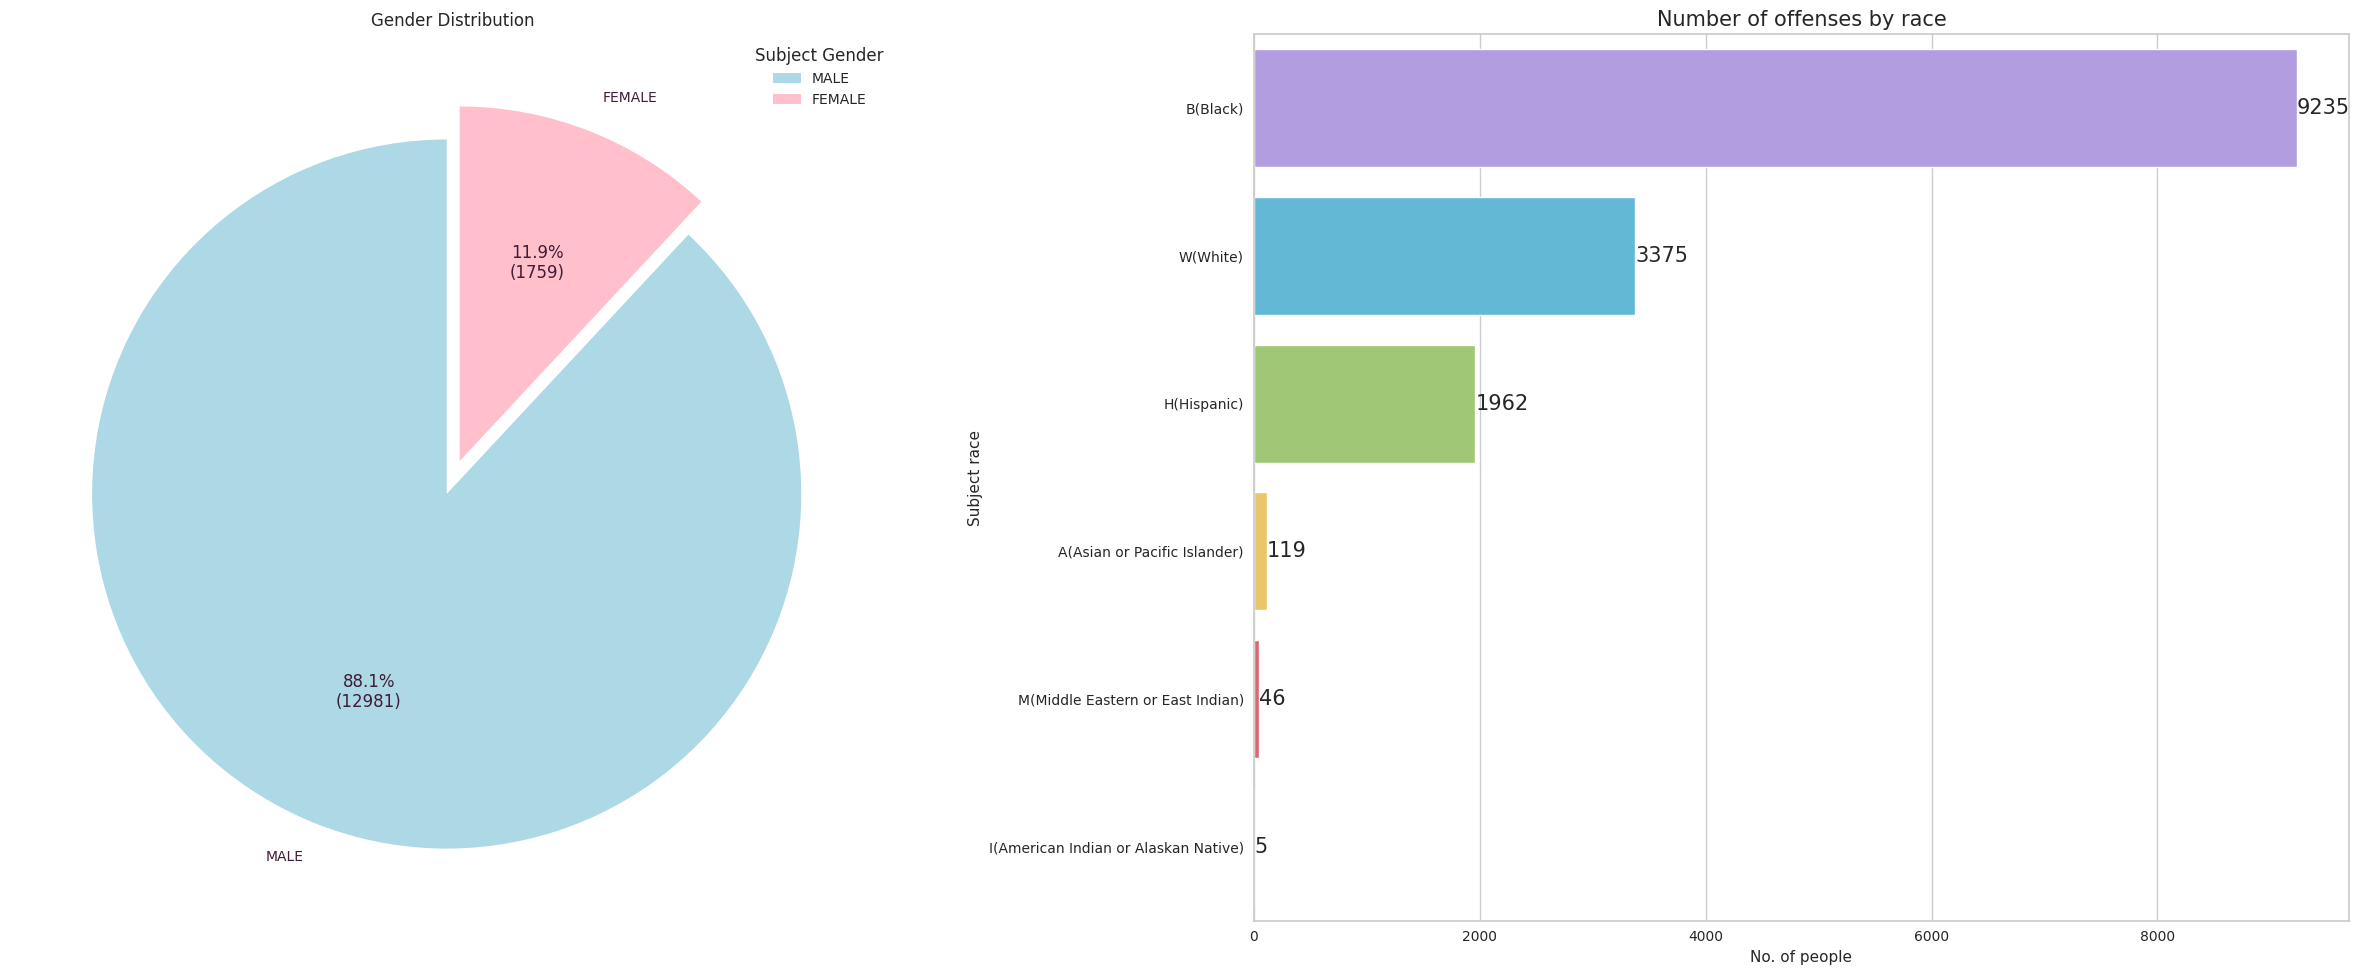

In [39]:
data = [len(df[df['SUBJECT_GENDER'] == feature]) for feature in df['SUBJECT_GENDER'].value_counts().index[0:2]]
labels = ['MALE', 'FEMALE']

colors = ['lightblue', 'pink']
explode = (0.05, 0.05)

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating the pie chart
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
plt.pie(data, labels=labels, explode=explode, colors=colors, 
        autopct=lambda pct: func(pct, data), startangle=90, textprops=dict(color="#3F1D38"))

plt.legend(labels, title="Subject Gender")
plt.title("Gender Distribution")

# Creating the bar chart
plt.subplot(1, 2, 2)
order = df['SUBJECT_RACE'].value_counts().index
colors = ['#AC92EB', '#4FC1E8', '#A0D568', '#FFCE54', '#ED5564', '#9E9FA5']

# Set the font size for titles
sns.set(font_scale=1.25)

ax = sns.countplot(data=df, y='SUBJECT_RACE', order=order, palette=colors) 

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of offenses by race')
plt.ylabel('Subject race')
plt.xlabel('No. of people')

# Show plots
plt.tight_layout()
plt.show()

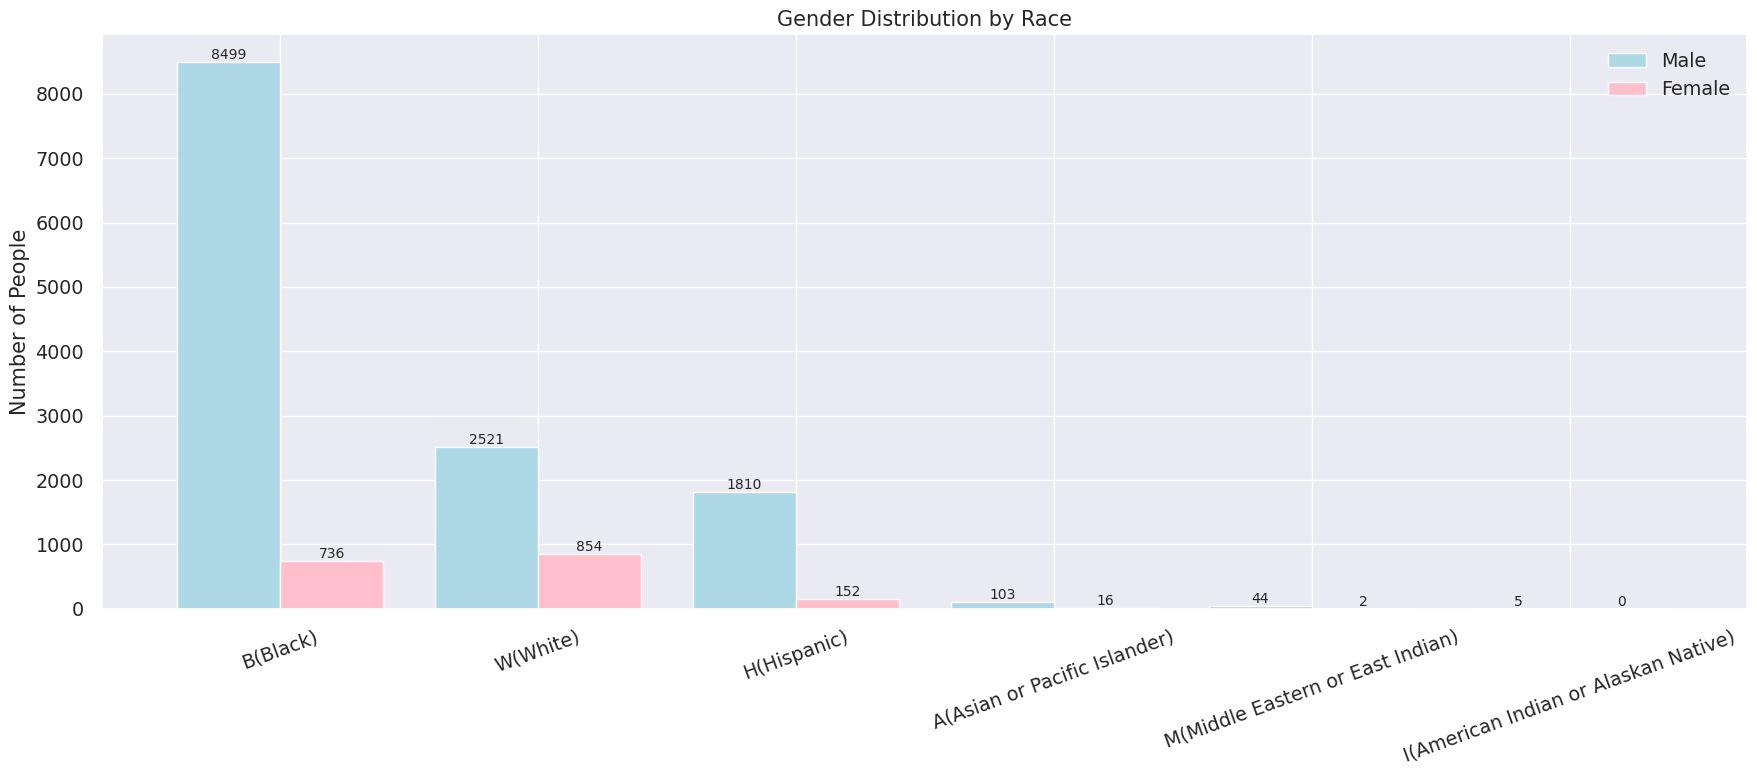

In [40]:
# Set the figure size
plt.figure(figsize=(18, 8))

# Extract the unique race categories to plot
race_to_plot = df['SUBJECT_RACE'].value_counts().index

# Filter data for male and female subjects
male = df[df['SUBJECT_GENDER'] == 'MALE']
female = df[df['SUBJECT_GENDER'] == 'FEMALE']

# Count the occurrences of gender and race combinations for male and female
male_counts = male['SUBJECT_RACE'].value_counts().reindex(race_to_plot, fill_value=0)
female_counts = female['SUBJECT_RACE'].value_counts().reindex(race_to_plot, fill_value=0)

# Set up positions for the bars
x = np.arange(len(race_to_plot))
width = 0.4  # Width of the bars
colors = ['lightblue', 'pink']  # Colors for male and female bars

# Create the bar plots
plt.bar(x - width/2, male_counts, width, color=colors[0], label='Male')
plt.bar(x + width/2, female_counts, width, color=colors[1], label='Female')

# Annotate the bars with their values
for i in range(len(race_to_plot)):
    plt.text(x[i] - width/2, male_counts[i], str(male_counts[i]), ha='center', va='bottom', fontsize=10)
    plt.text(x[i] + width/2, female_counts[i], str(female_counts[i]), ha='center', va='bottom', fontsize=10)

# Set the x-axis labels and tick rotation
plt.xticks(x, race_to_plot, rotation=20)

# Set labels, legend, and title
plt.ylabel("Number of People")
plt.legend()
plt.title("Gender Distribution by Race")

# Display the plot
plt.tight_layout()
plt.show()

### Number of offences distrubuted by Years and Months

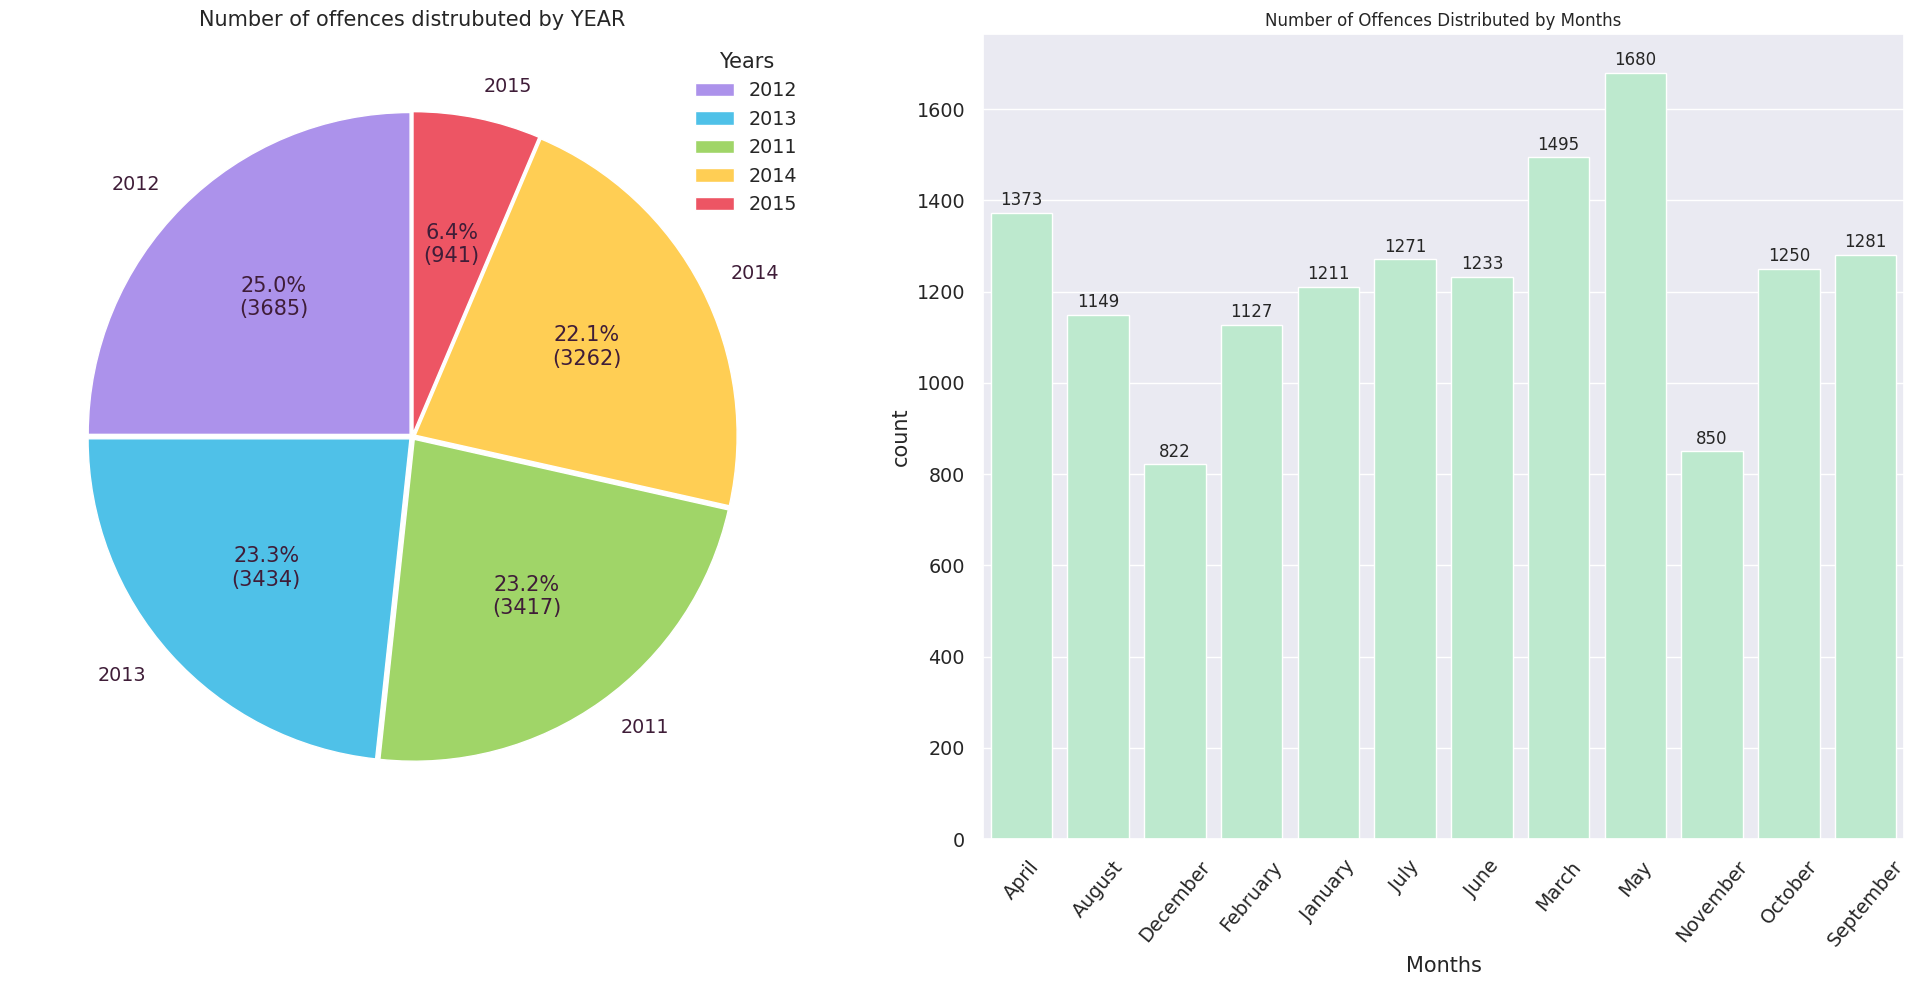

In [41]:
# Pie Chart

# Creating data
data = [len(df[df['INCIDENT_YEAR'] == feature]) for feature in df['INCIDENT_YEAR'].value_counts().index]
labels = df['INCIDENT_YEAR'].value_counts().index

colors = ['#AC92EB', '#4FC1E8', '#A0D568', '#FFCE54', '#ED5564'] # creating color parameters
explode = (0.01, 0.01, 0.01, 0.01, 0.01) # creating explode data

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating plot
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.pie(data, labels=labels, explode=explode, colors=colors, autopct=lambda pct: func(pct, data), 
        startangle=90, textprops=dict(color ="#3F1D38"))

# Adding legend
plt.legend(labels, title ="Years", loc ='best',)

plt.title("Number of offences distrubuted by YEAR")

# Bat chart
plt.subplot(1, 2, 2)
order = df['INCIDENT_MONTH'].value_counts().sort_index().index

# Set the font size for titles
sns.set(font_scale=1)

ax = sns.countplot(data=df, x='INCIDENT_MONTH', order=order, color='#B5F1CC') 
plt.xticks(rotation=50)

for label in ax.containers[0]:
    ax.annotate(format(int(label.get_height())), 
                (label.get_x() + label.get_width() / 2., label.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    
plt.title('Number of Offences Distributed by Months')
plt.xlabel('Months')

plt.tight_layout() 
plt.show()

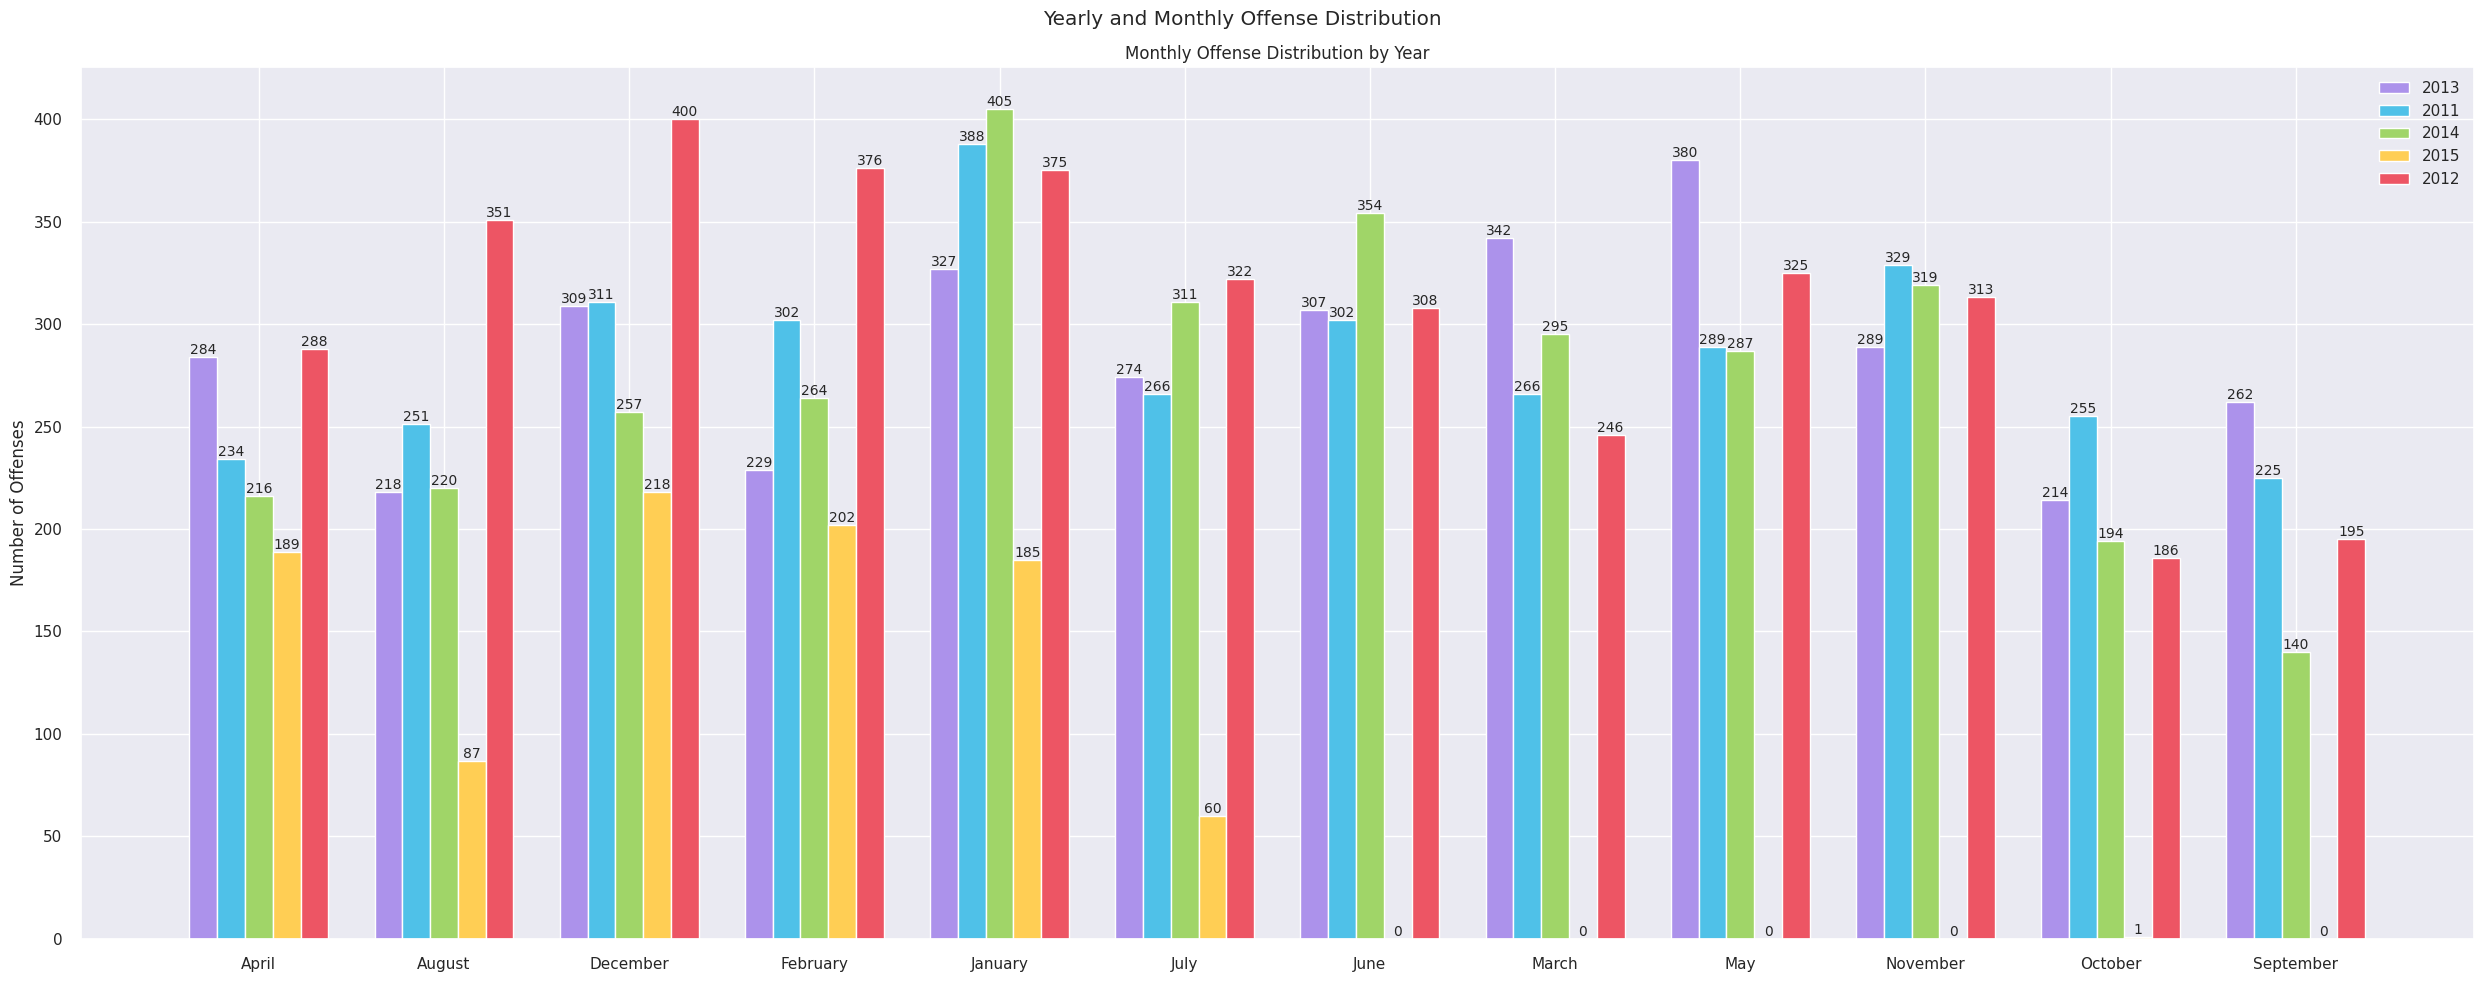

In [42]:
# Get unique years in your data
years_to_plot = df['INCIDENT_YEAR'].unique()

# Create a mapping from month names to their numeric values
month_name_to_number = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

# An empty list to store monthly counts for each year
values = []

for year in years_to_plot:
    c = df[df['INCIDENT_YEAR'] == year]
    value = c['INCIDENT_MONTH'].map(month_name_to_number)  # Map month names to numbers
    value_counts = value.value_counts().sort_index()

    # Create an empty list to store the counts for all 12 months
    monthly_counts = [0] * 12
    
    # Fill in the counts for the months that exist
    for month, count in value_counts.items():
        monthly_counts[month - 1] = count  # Subtract 1 to adjust for zero-based indexing

    values.append(monthly_counts)

x = np.arange(1, 13)
width = 0.15
colors = ['#AC92EB', '#4FC1E8', '#A0D568', '#FFCE54', '#ED5564']

plt.figure(figsize=(25, 10))
for n in range(len(years_to_plot)):
    plt.bar(x + (n - 2) * width, values[n], width=width, color=colors[n])

# Annotate the bars with their values
for n in range(len(years_to_plot)):
    for i in range(12):
        plt.text(x[i] + (n - 2) * width, values[n][i], str(values[n][i]), ha='center', va='bottom', fontsize=10)

order = df['INCIDENT_MONTH'].value_counts().sort_index().index
plt.xticks(x, order)
plt.ylabel("Number of Offenses")
plt.legend(years_to_plot)  # Use the extracted unique years
plt.title("Monthly Offense Distribution by Year")

# Adding an overall title to the entire figure
plt.suptitle("Yearly and Monthly Offense Distribution")

# Show plots
plt.tight_layout()
plt.show()

### Number of Offences Distributed by Location

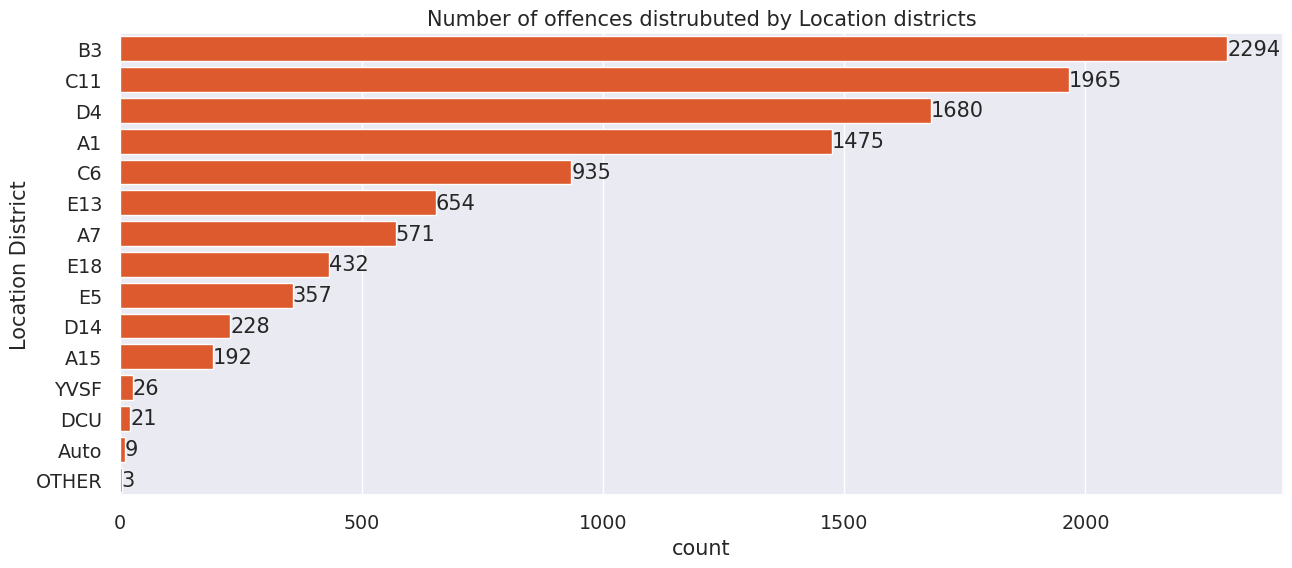

In [43]:
# Bar chart 1: Location district
plt.figure(figsize=(15, 6))
order = df['LOCATION_DISTRICT'].value_counts().index[1:16]

# Set the font size for titles
sns.set(font_scale=1.25)

ax = sns.countplot(y=df['LOCATION_DISTRICT'], order=order, color='#F94C10')

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of offences distrubuted by Location districts')
plt.ylabel('Location District')

plt.show()

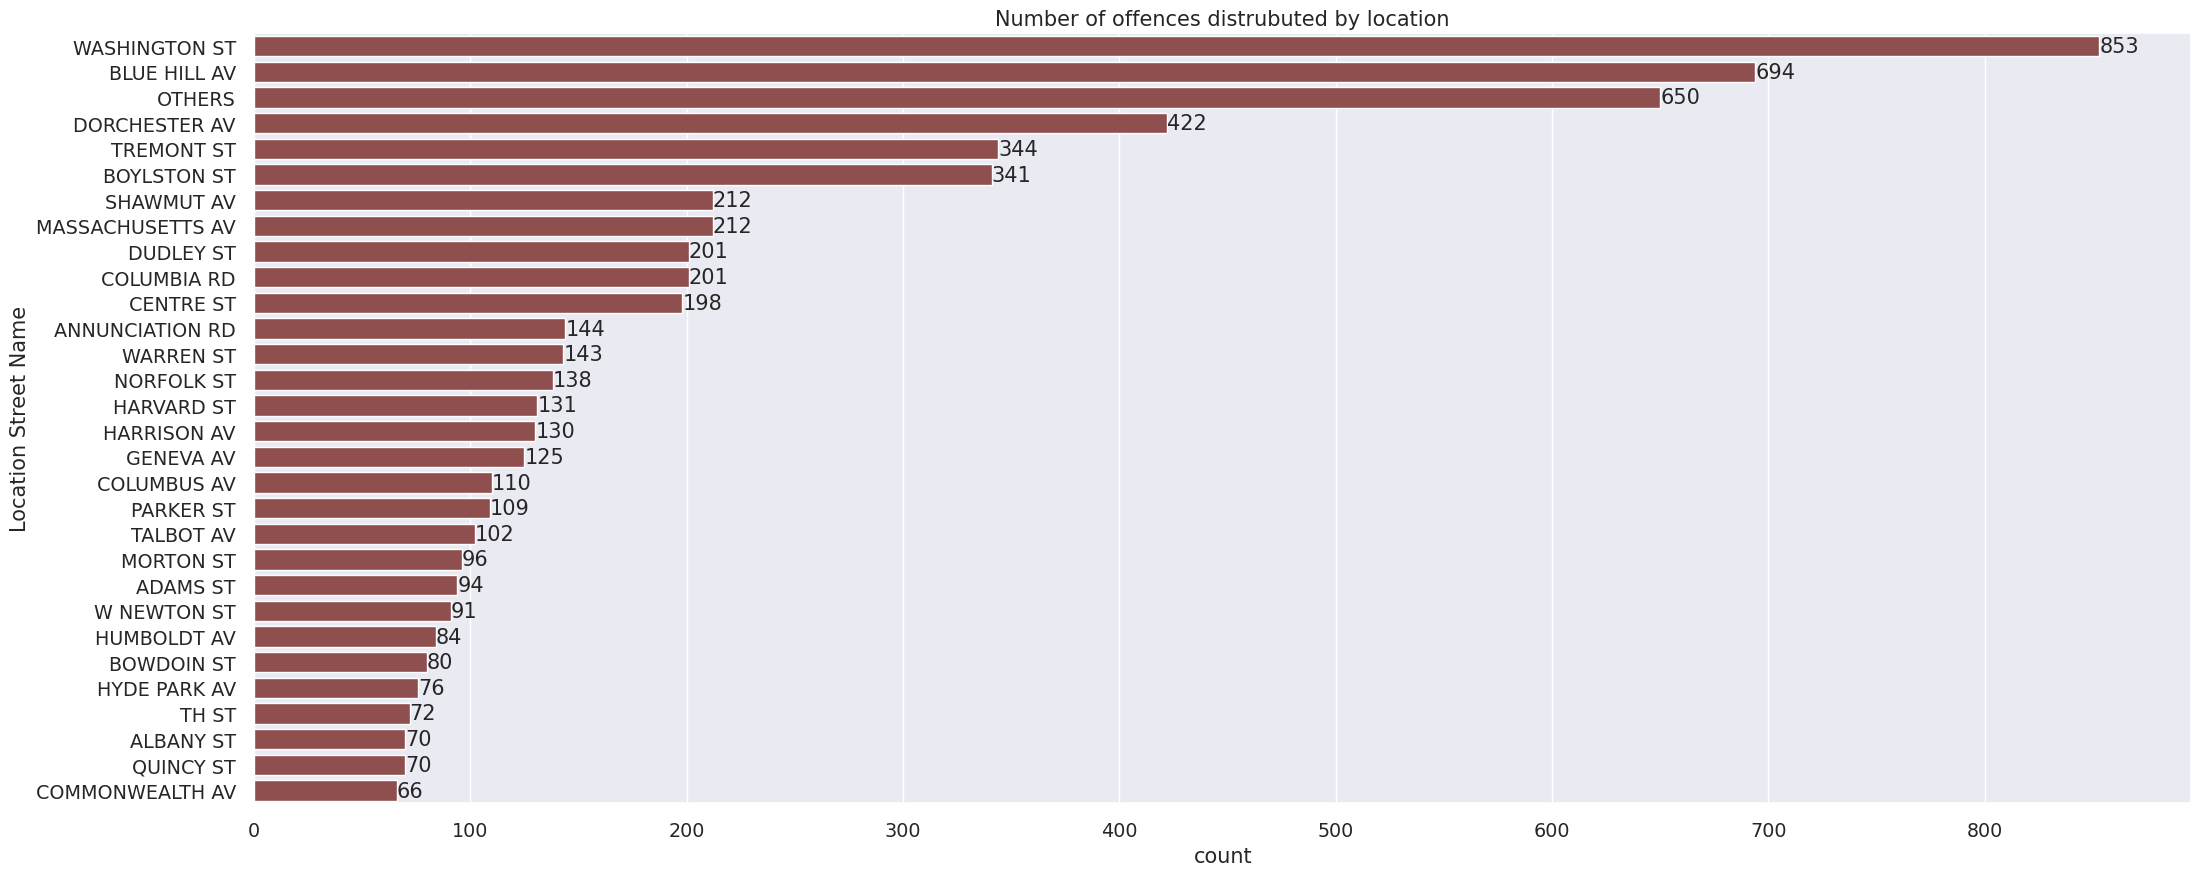

In [44]:
# Bar chart: Location
plt.figure(figsize=(25, 10))
order = df['LOCATION_STREET_ADDRESS'].value_counts().index[0:30]

# Set the font size for titles
sns.set(font_scale=1.25)

ax = sns.countplot(y=df['LOCATION_STREET_ADDRESS'], order=order, color='#9A4444')

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of offences distrubuted by location')
plt.ylabel('Location Street Name')

plt.show()

### Officer Related Information

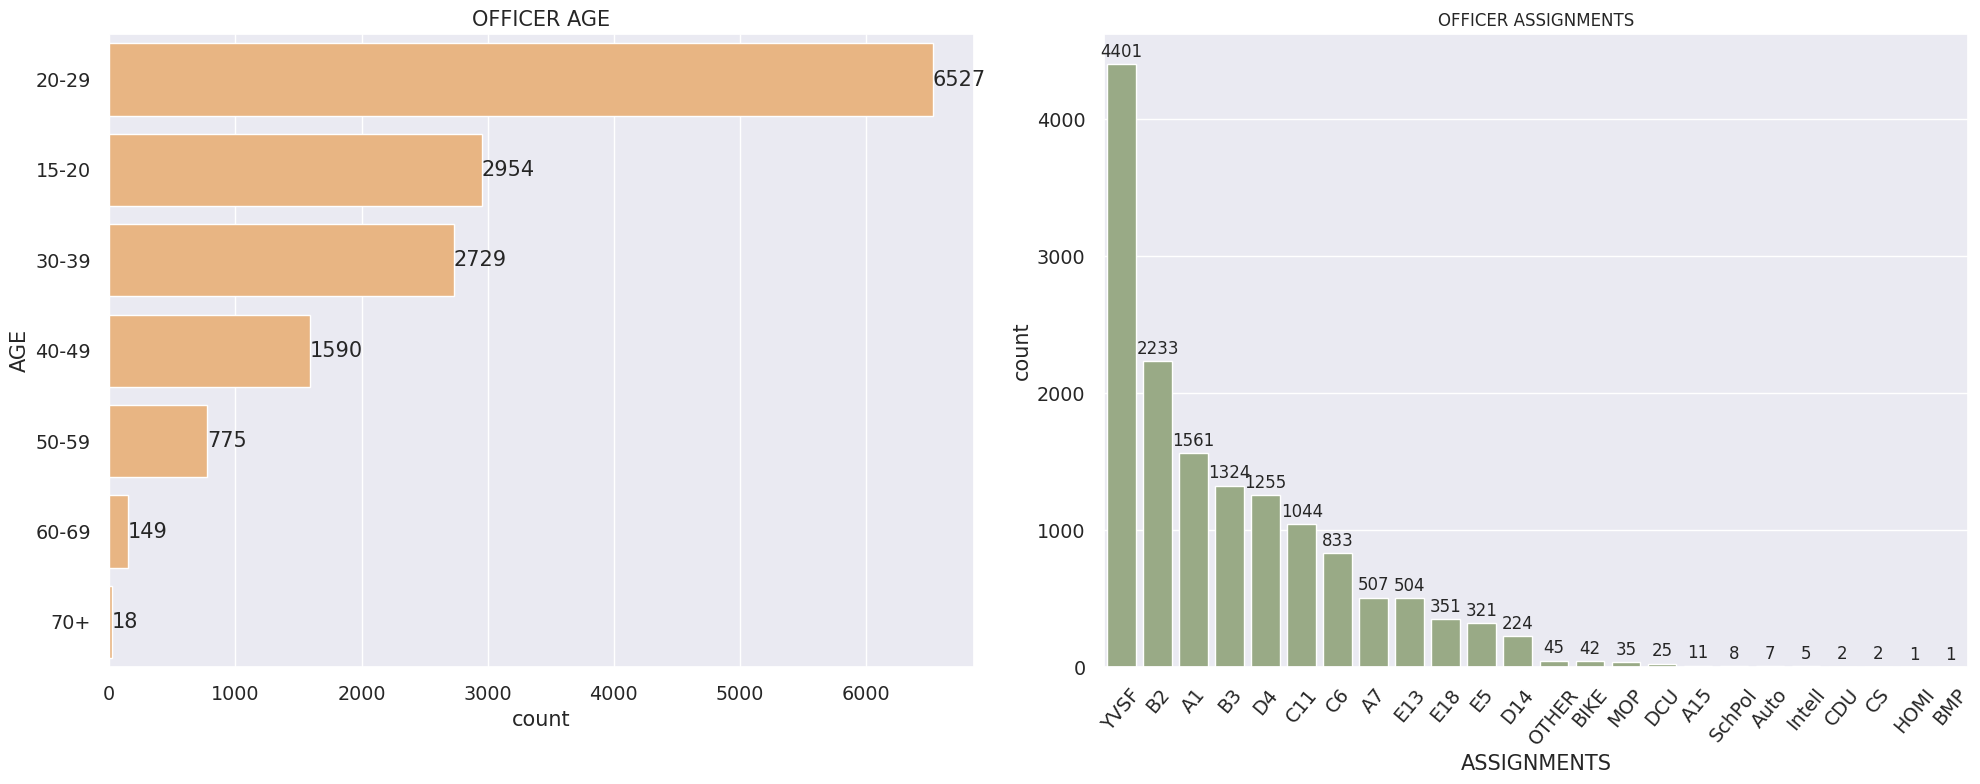

In [45]:
# Creating data
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
order = df['OFFICER_AGE'].value_counts().index[:12]
ax = sns.countplot(y=df['OFFICER_AGE'], order=order, color='#F9B572')

for label in ax.containers:
    ax.bar_label(label)

plt.ylabel('AGE')
plt.title("OFFICER AGE")

# Bat chart
plt.subplot(1, 2, 2)
order = df['OFFICER_ASSIGNMENT.1'].value_counts().index

# Set the font size for titles
sns.set(font_scale=1)

ax = sns.countplot(data=df, x='OFFICER_ASSIGNMENT.1', order=order, color='#99B080') 
plt.xticks(rotation=50)

for label in ax.containers[0]:
    ax.annotate(format(int(label.get_height())), 
                (label.get_x() + label.get_width() / 2., label.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    
plt.title('OFFICER ASSIGNMENTS')
plt.xlabel('ASSIGNMENTS')

plt.tight_layout() 
plt.show()

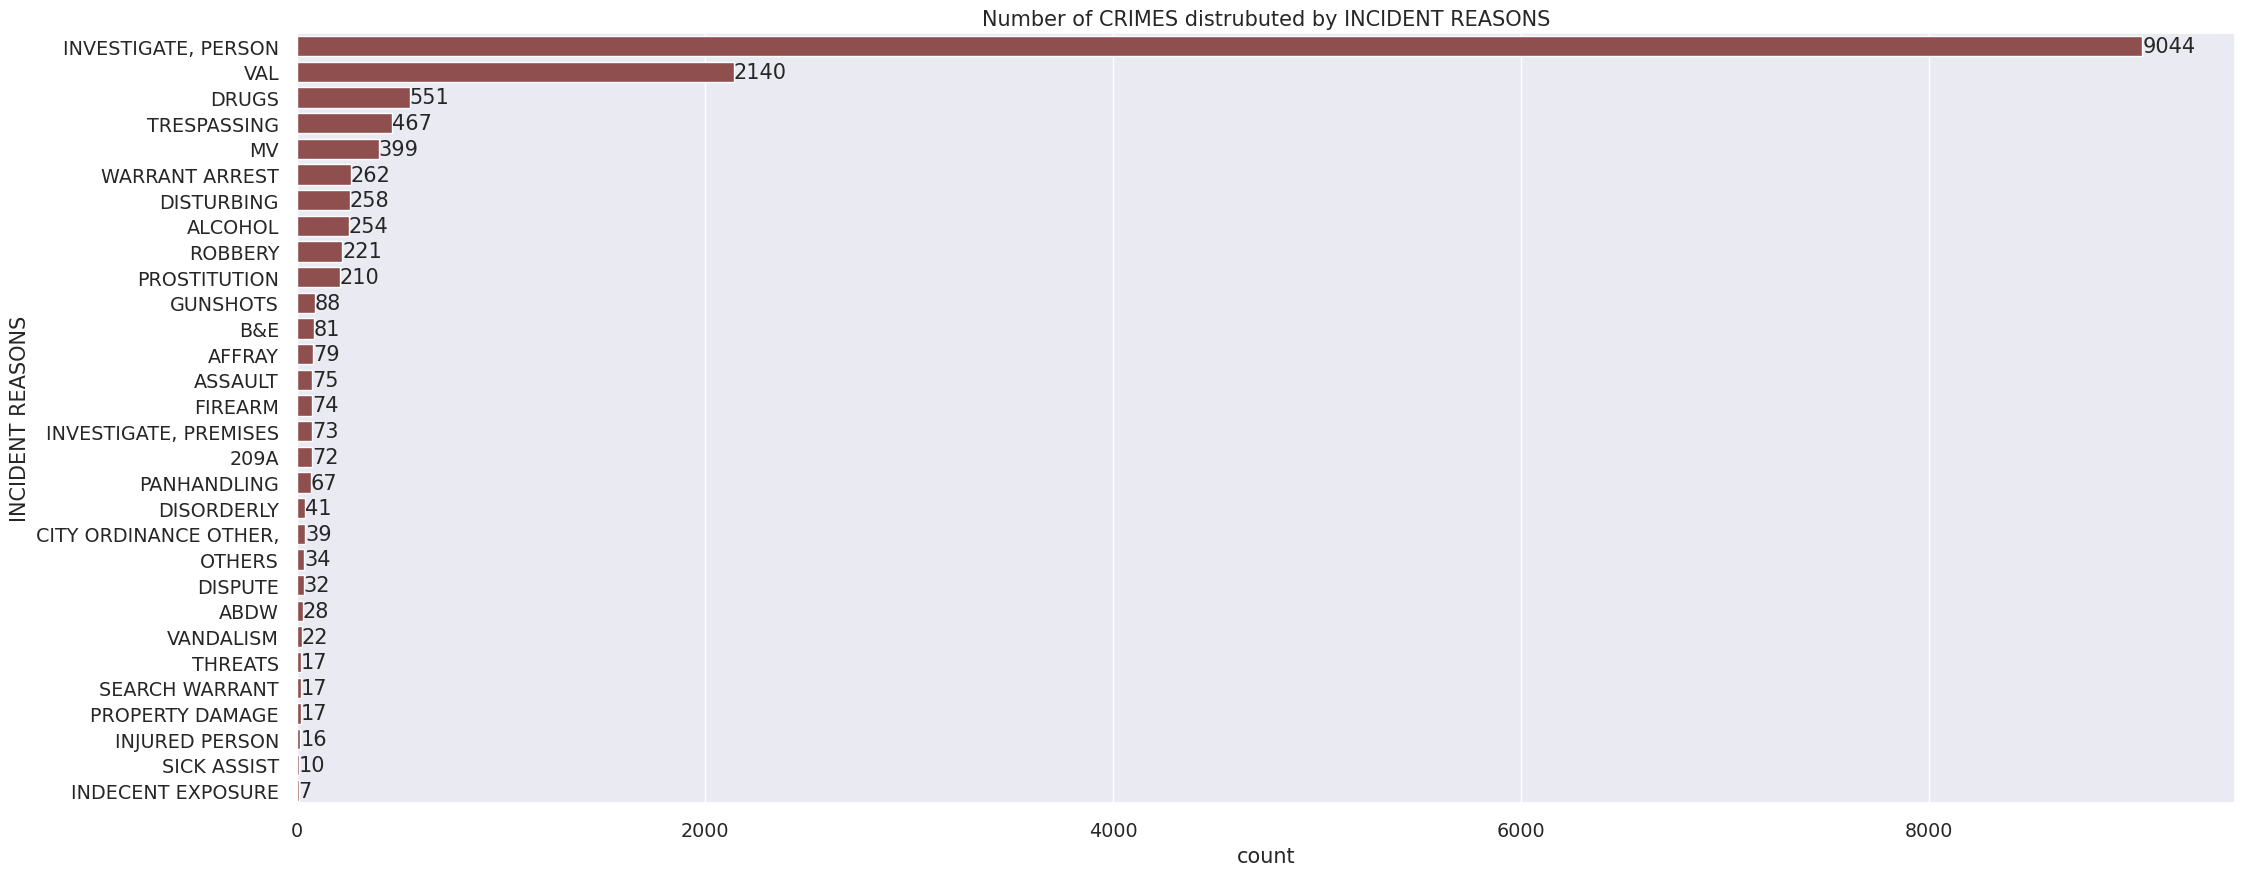

In [46]:
# Bar chart 1: Location
plt.figure(figsize=(25, 10))
order = df['INCIDENT_REASON.1'].value_counts().index[0:30]

# Set the font size for titles
sns.set(font_scale=1.25)

ax = sns.countplot(y=df['INCIDENT_REASON.1'], order=order, color='#9A4444')

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of CRIMES distrubuted by INCIDENT REASONS')
plt.ylabel('INCIDENT REASONS')

plt.show()

# Step 3: Dimensionality Reduction

In [47]:
# 90% percent
mca = MCA(n_components=1040, n_iter=50, copy=True, check_input=True, random_state=42, one_hot=True)
mca_results = mca.fit(encoded_df)

In [48]:
mca_results.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.315,0.29%,0.29%
1,0.269,0.25%,0.54%
2,0.261,0.24%,0.78%
3,0.252,0.23%,1.01%
4,0.246,0.23%,1.24%
...,...,...,...
1035,0.091,0.08%,90.81%
1036,0.091,0.08%,90.90%
1037,0.091,0.08%,90.98%


In [49]:
features = mca_results.column_contributions_.sum(axis=1)[:1040].keys()

selected_features = []

for feature in features:
    for i in range(len(df.columns)):
        if df.columns[i] in feature:
            selected_features.append(df.columns[i])
            
selected_features = list(set(selected_features))
selected_features

['INCIDENT_REASON.1',
 'LOCATION_STREET_ADDRESS',
 'INCIDENT_MONTH',
 'LOCATION_DISTRICT',
 'SUBJECT_RACE',
 'OFFICER_AGE',
 'INCIDENT_YEAR',
 'OFFICER_ASSIGNMENT.1',
 'SUBJECT_DETAILS.2',
 'SUBJECT_GENDER',
 'SUBJECT_DETAILS']

In [50]:
# Scaling
scale = StandardScaler()
scaled_data = scale.fit_transform(encoded_df)
reduced_df = pd.DataFrame(scaled_data, columns=encoded_df.columns)[selected_features]

reduced_df.head()

,INCIDENT_REASON.1,LOCATION_STREET_ADDRESS,INCIDENT_MONTH,LOCATION_DISTRICT,SUBJECT_RACE,OFFICER_AGE,INCIDENT_YEAR,OFFICER_ASSIGNMENT.1,SUBJECT_DETAILS.2,SUBJECT_GENDER,SUBJECT_DETAILS
0,-0.174967,-0.977481,-0.765312,-0.598281,1.785126,-1.223316,0.295605,1.315564,-0.088674,0.368201,0.356582
1,-0.174967,-1.473445,-0.182115,1.238234,1.179833,-1.223316,-1.325907,0.141413,-1.580957,0.368201,0.356582
2,-0.174967,1.108576,-0.765312,-1.057410,-0.636046,-1.223316,0.295605,-1.150154,-0.088674,0.368201,-2.804408
3,-0.174967,-0.135844,-0.473714,-0.598281,-0.636046,-0.352439,-1.325907,-0.915324,-1.580957,0.368201,0.356582
4,-0.174967,1.430202,0.401081,0.319976,-0.636046,-0.352439,0.295605,1.315564,0.657467,0.368201,0.356582


# Step 4: Clustering

### Choosing the Number of clusters k

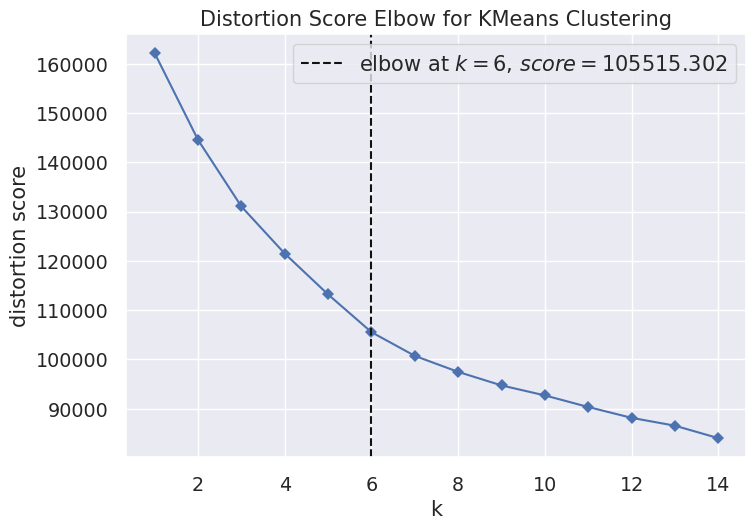

In [51]:
# Elbow Method to find optimal k
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 15), timings=False)
visualizer.fit(reduced_df)
visualizer.show()

# Get optimal k from the Elbow method
optimal_k = visualizer.elbow_value_

In [52]:
optimal_k

6

### K-means clustering

In [53]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, max_iter=100).fit(scaled_data)
 
# extract centroids of clusters into a dataframe
centers = kmeans.cluster_centers_

# extract cluster labels
labels = kmeans.labels_ 

# Step 5: Cluster Analysis

### Analyzing clusters characteristics

In [54]:
cluster_characteristics = []
size_of_clusters = []

for i in range(optimal_k):    
    cluster_data = scaled_data[labels == i]
    cluster_size = len(cluster_data)    
    cluster_center = centers[i]
    avg_distance = np.mean(np.linalg.norm(cluster_data - cluster_center, axis=1))    
    cluster_characteristics.append({
        "Cluster": i,        
        "Size": cluster_size,
        "Avg Distance": avg_distance,    
    })
    
cluster_characteristics

[{'Cluster': 0, 'Size': 2597, 'Avg Distance': 2.6163281934699225},
 {'Cluster': 1, 'Size': 3867, 'Avg Distance': 2.3464554720047177},
 {'Cluster': 2, 'Size': 2200, 'Avg Distance': 2.7061428159098564},
 {'Cluster': 3, 'Size': 1648, 'Avg Distance': 3.1444808120071297},
 {'Cluster': 4, 'Size': 2981, 'Avg Distance': 2.295419872044546},
 {'Cluster': 5, 'Size': 1449, 'Avg Distance': 2.9088412931897003}]

In [55]:
# Print the cluster centroids
print("Cluster Centroids:")
print(centers)

Cluster Centroids:
[[ 3.53950704e-01  2.28772687e-02  3.56581539e-01 -6.09242821e-01
  -1.75765168e+00 -6.94028953e-04  1.26764055e-01  2.51536630e-02
   1.18251023e-02  2.69550685e-02  2.28142287e-03]
 [ 3.68201481e-01  3.80406604e-01  3.56581539e-01 -4.71549217e-01
   5.52609812e-01  5.15200207e-02  1.03939134e+00 -2.49175446e-01
   1.38313206e-01  1.90881663e-02  6.62224939e-02]
 [ 3.68201481e-01 -5.03529035e-02  3.56581539e-01  1.77026876e+00
   2.77952130e-01 -1.64971635e-01 -4.87078554e-01  4.85978410e-01
  -5.19141939e-02 -3.90997262e-02  1.02305800e-02]
 [-1.91354125e-01  8.30289706e-02 -2.80440766e+00  9.26560100e-02
   3.62860435e-02  1.60820645e-02 -8.03081399e-02 -4.22193583e-01
  -9.10780750e-02 -2.20365817e-04 -2.86220899e-02]
 [ 3.68201481e-01 -5.20628912e-01  3.56581539e-01 -5.27471755e-01
   5.29893298e-01  3.75270672e-02 -8.75961728e-01  4.68716686e-02
  -5.32621529e-02 -3.84222209e-02 -4.84674530e-02]
 [-2.71590434e+00 -5.59648930e-03  3.23859083e-01  6.42212330e-01


### Silhouette Score, Davies-Bouldin Index, Variance Ratio Criterion, Within-Cluster Sum of Squares (WCSS)

In [56]:
silhouette_avg = silhouette_score(scaled_data, kmeans.labels_)
print('Silhouette Score', silhouette_avg)

db_index = davies_bouldin_score(scaled_data, kmeans.labels_)
print('Davies-Bouldin Index:', db_index)

ch_score = calinski_harabasz_score(scaled_data, kmeans.labels_)
print('Calinski-Harabasz Index (Variance Ratio Criterion):', ch_score)

wcss = kmeans.inertia_
print('Within-Cluster Sum of Squares (WCSS):', wcss)

Silhouette Score 0.1308204487736524
Davies-Bouldin Index: 1.9315792227418676
Calinski-Harabasz Index (Variance Ratio Criterion): 1611.2150237231283
Within-Cluster Sum of Squares (WCSS): 104844.33730833916


In [57]:
reduced_df['CLUSTER'] = labels
reduced_df['CLUSTER'] = reduced_df['CLUSTER'].astype(str)
reduced_df.head()

,INCIDENT_REASON.1,LOCATION_STREET_ADDRESS,INCIDENT_MONTH,LOCATION_DISTRICT,SUBJECT_RACE,OFFICER_AGE,INCIDENT_YEAR,OFFICER_ASSIGNMENT.1,SUBJECT_DETAILS.2,SUBJECT_GENDER,SUBJECT_DETAILS,CLUSTER
0,-0.174967,-0.977481,-0.765312,-0.598281,1.785126,-1.223316,0.295605,1.315564,-0.088674,0.368201,0.356582,2
1,-0.174967,-1.473445,-0.182115,1.238234,1.179833,-1.223316,-1.325907,0.141413,-1.580957,0.368201,0.356582,0
2,-0.174967,1.108576,-0.765312,-1.057410,-0.636046,-1.223316,0.295605,-1.150154,-0.088674,0.368201,-2.804408,3
3,-0.174967,-0.135844,-0.473714,-0.598281,-0.636046,-0.352439,-1.325907,-0.915324,-1.580957,0.368201,0.356582,0
4,-0.174967,1.430202,0.401081,0.319976,-0.636046,-0.352439,0.295605,1.315564,0.657467,0.368201,0.356582,1


In [58]:
# Calculate mean and median for each cluster
cluster_means = reduced_df.groupby('CLUSTER').mean()
cluster_medians = reduced_df.groupby('CLUSTER').median()

# Print the results
print("Cluster Means:")
print(cluster_means)

print("\nCluster Medians:")
print(cluster_medians)

Cluster Means:
         INCIDENT_REASON.1  LOCATION_STREET_ADDRESS  INCIDENT_MONTH  \
CLUSTER                                                               
0                -0.000694                 0.002281        0.026955   
1                 0.051312                 0.066510        0.018467   
2                -0.164972                 0.010231       -0.039100   
3                 0.016082                -0.028622       -0.000220   
4                 0.037816                -0.048687       -0.037539   
5                 0.018692                -0.064405        0.039250   

         LOCATION_DISTRICT  SUBJECT_RACE  OFFICER_AGE  INCIDENT_YEAR  \
CLUSTER                                                                
0                 0.022877     -0.609243     0.025154       0.011825   
1                 0.380350     -0.471536    -0.248168       0.137941   
2                -0.050353      1.770269     0.485978      -0.051914   
3                 0.083029      0.092656    -0.422194   

### Cluster Visualization

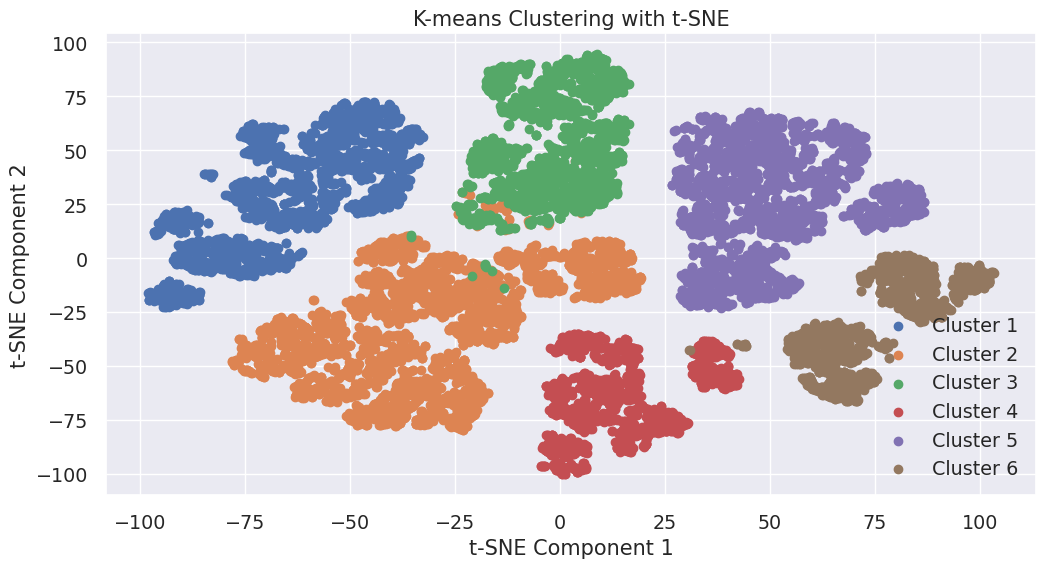

In [59]:
# Visualization of kmeans with TSNE

tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(reduced_df)

plt.figure(figsize=(12, 6))
for i in range(optimal_k):
    plt.scatter(tsne_results[labels == i][:, 0], 
                tsne_results[labels == i][:, 1], label=f'Cluster {i + 1}')
    
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('K-means Clustering with t-SNE')
plt.legend(loc ='best')
plt.show()

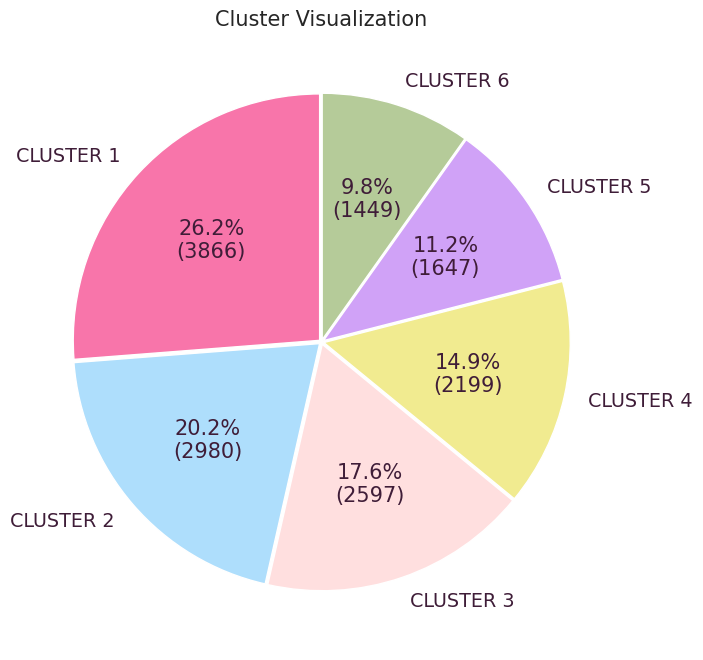

In [60]:
data = [len(reduced_df[reduced_df['CLUSTER'] == feature]) for feature in reduced_df['CLUSTER'].value_counts().index]
labels = ['CLUSTER 1', 'CLUSTER 2', 'CLUSTER 3', 'CLUSTER 4', 'CLUSTER 5', 'CLUSTER 6']

colors = ['#F875AA', '#AEDEFC', '#FFDFDF', '#F1EB90', '#D0A2F7', '#B5CB99']
explode = (0.01, 0.01, 0.01, 0.01, 0.01, 0.01)

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating the pie chart
plt.figure(figsize=(15, 8))
plt.pie(data, labels=labels, explode=explode, colors=colors, 
        autopct=lambda pct: func(pct, data), startangle=90, textprops=dict(color="#3F1D38"))

plt.title('Cluster Visualization')
plt.show()

In [61]:
df['CLUSTERS'] = kmeans.labels_

def cluster_profile(df):
    profiles = {}
    
    for column in df.columns:
        if column != 'CLUSTERS':
            profiles[f'{column}'] = df[column].value_counts().keys()[0]
    
    return profiles

In [62]:
cluster_profile = df.groupby('CLUSTERS').apply(cluster_profile)
cluster_profile_df = pd.DataFrame(cluster_profile.tolist(), index=cluster_profile.index)

cluster_profile_df

,SUBJECT_GENDER,LOCATION_DISTRICT,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,INCIDENT_REASON.1,OFFICER_ASSIGNMENT.1,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH,LOCATION_STREET_ADDRESS
CLUSTERS,,,,,,,,,,,
0,MALE,B2,YES,B(Black),Dark,"INVESTIGATE, PERSON",YVSF,20-29,2013,May,WASHINGTON ST
1,MALE,B2,YES,B(Black),Med,"INVESTIGATE, PERSON",YVSF,20-29,2014,May,WASHINGTON ST
2,MALE,A1,YES,W(White),Light,"INVESTIGATE, PERSON",A1,20-29,2012,March,WASHINGTON ST
3,MALE,B2,NO,B(Black),Med,"INVESTIGATE, PERSON",YVSF,20-29,2011,March,OTHERS
4,MALE,B2,YES,B(Black),Med,"INVESTIGATE, PERSON",B2,20-29,2012,May,BLUE HILL AV
5,FEMALE,B2,YES,W(White),Med,"INVESTIGATE, PERSON",A1,20-29,2012,May,DORCHESTER AV
